# gplearn Survival

This notebook explores how to implement proportional hazards models with symbolic regression (with `gplearn`). This is a pre-requisite to doing it with SHAREs. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("whitegrid")

## 0. Test Data

We load the example Rossi dataset from `lifelines`, on which Cox PH achieves C-index of ~0.64.

In [4]:
from survshares.datasets import Rossi, Metabric, GBSG2


# Test dataset - Cox achieves C-index of 0.6403292470997135
X, T, E = Rossi().load(normalise=True)
feature_names = Rossi.features
calibration_time = Rossi.tmax

# Test dataset - Cox achieves C-index of 0.6391503770136181
# X, T, E = Metabric().load(normalise=True)
# feature_names = Metabric.features
# calibration_time = Metabric.tmax

# Test dataset - Cox achieves C-index of 0.5437638695233794
# X, T, E = GBSG2().load(normalise=True)
# feature_names = GBSG2.features
# calibration_time = GBSG2.tmax

## 1. Baseline Model - Cox PH

We fit a standard Cox PH as the model to beat. 

In [11]:
from lifelines import CoxPHFitter
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score

X_df = pd.DataFrame(X, columns=feature_names).assign(time=T, event=E)
cph = CoxPHFitter()
cph.fit(X_df, duration_col="time", event_col="event")
cph.print_summary()

# Double check the concordance
from lifelines.utils import concordance_index

c_index = concordance_index(T, -cph.predict_partial_hazard(X), E)
y, t = Surv.from_arrays(E, T), np.unique(T).astype(float)[1:-1]
ibs = integrated_brier_score(y, y, cph.predict_survival_function(X, times=t).T, t)
print(f"C-index: {c_index}")
print(f"IBS: {ibs}")    

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-05-16 15:04:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.19      0.83      0.10           -0.38           -0.00                0.69                1.00
age       -0.35      0.70      0.13           -0.61           -0.09                0.54                0.92
race       0.10      1.11      0.10           -0.10            0.30                0.91                1.35
wexp      -0.07      0.93      0.11           -0.28            0.13                0.76                1.14
mar       -0.14      0.87      0.13           -0.39            0.10                0.68                1.11
paro      -0.04      0.96      0.10           -0.23            0.15                0.80                1.16
prio       0.26      1.30      0.08            0.10            0.43                1.11                1.53

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

C-index: 0.6403292470997135
IBS: 0.09467578840277145


## 2. Fitness Metrics
There are 3 options: 
 - The concordance (c-index) 
 - The DeepSurv/CoxTime ranking loss
 - The Cox partial likelihood (very similar)

DeepSurv/CoxTime also includes a shrink penalty in its loss to penalise the neural networks $g(t|x)$ from having values too far from 0. 

`gplearn` fitness functions normally depend only on `y_true` and `y_pred`, but we also require the event/censoring indicator. We pass the indicator as the `sample_weight` as a workaround to avoid modifying `gplearn` yet. 

In [5]:
# C-index
from lifelines.utils import concordance_index
from gplearn_clean.gplearn.fitness import make_fitness
from sklearn.metrics import make_scorer
import warnings

def metric_c_index(y_true, y_pred, sample_weight):
    """
    Protected concordance score metric for gplearn. Greater is better.
    """
    # y_true is the event time, y_pred is the predicted risk
    # sample_weight is the event indicator
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        try:
            return concordance_index(y_true, np.exp(y_pred), sample_weight)
        except ZeroDivisionError:  # In case of no unambigous pairs
            return 0.5
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return 0.5

scorer_c_index = make_scorer(metric_c_index, greater_is_better=True)

In [6]:
def metric_ranking_loss(y_true, y_pred, sample_weight):
    """
    Ranking loss metric for gplearn (similar to DeepSurv and CoxTime). Less is better.
    """
    # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
    # Inputs must be sorted by descending event time
    ordering = np.argsort(y_true)[::-1]
    y_true = y_true[ordering]
    y_pred = pd.Series(y_pred[ordering])
    sample_weight = pd.Series(sample_weight[ordering])

    gamma = y_pred.max()
    eps = 1e-7

    try:
        log_cumsum_h = np.log(np.exp(y_pred.sub(gamma)).cumsum(0).add(eps)).add(gamma)
        pll = y_pred.sub(log_cumsum_h).mul(sample_weight).sum() / sample_weight.sum()
        return -pll  # Flip the sign to make it a minimization function
    except RuntimeWarning:  # In case of invalid log or exp overflow
        return np.inf

In [7]:
from pycox.evaluation.metrics import partial_log_likelihood_ph

def metric_partial_likelihood(y_true, y_pred, sample_weight):
    """
    Cox partial likelihood metric for gplearn. Less is better.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        # We want to minimise the negative partial log likelihood
        # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
        try:
            pll = partial_log_likelihood_ph(y_pred, y_true, sample_weight, mean=True)
            return -pll  # Flip the sign to make it a minimization function
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return np.inf

In [8]:
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score
def metric_integrated_brier(surv_pred, E_train, T_train, E_test=None, T_test=None):
    """
    Integrated Brier score for pycox-type models
    """
    E_test = E_test if E_test is not None else E_train 
    T_test = T_test if T_test is not None else T_train

    y_train, y_test = Surv.from_arrays(E_train, T_train), Surv.from_arrays(E_test, T_test)

    times = surv_pred.index.values[1:-1]
    times = times[(times > T_test.min()) & (times < T_test.max())]
    surv_pred = surv_pred.loc[times, :].T

    return integrated_brier_score(y_train, y_test, surv_pred, times)

In [9]:
import torch 
from torchsurv.loss.cox import neg_partial_log_likelihood
import warnings 
def metric_torchsurv_pll(y_true, y_pred, sample_weight):
    """
    Cox partial likelihood metric for gplearn. Less is better.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        npll = neg_partial_log_likelihood(torch.tensor(y_pred), torch.tensor(sample_weight, dtype=torch.bool), torch.tensor(y_true))
        return npll.item()


In [12]:
# Testing with Cox PH
h_pred = cph.predict_partial_hazard(X)
surv_pred = cph.predict_survival_function(X)
print(f"C-index: {metric_c_index(T, -h_pred, E)}")
print(f"Ranking loss: {metric_ranking_loss(T, h_pred, E)}")
print(f"pycox PLL: {metric_partial_likelihood(T, h_pred, E)}")
print(f"torchsurv NPLL: {metric_torchsurv_pll(T, h_pred, E)}")
print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

C-index: 0.6403292470997135
Ranking loss: 4.948968147835974
pycox PLL: 5.985998659506427
torchsurv NPLL: 13.910039084216008
IBS: 0.09467578840277145


## 3. Other Estimands - $h_0$, $H$, and $S$

Given our predicted $h(t|x)$, we also need to obtain the baseline $h_0$ (which also depends on our fitted $h$), cumulative hazards $H(t|x)$ and $H_0(t|x)$, and finally the survival $S(t|x)$. 

The ways to obtain these are standardised irrespective of if we used Cox or SymReg for $h$.

In [ ]:
from pycox.models.cox import _CoxPHBase
import torchtuples as tt

class CustomPH(_CoxPHBase):
    def __init__(self, *args, **kwargs):
        pass

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return np.log(cph.predict_partial_hazard(X).to_numpy())

cc = CustomPH()

# This must run & store results in the cc object before predict_cumulative_hazards can run
h0_pred = cc.compute_baseline_hazards(X, (T, E))
h0_true = cph.baseline_hazard_["baseline hazard"]

H0_pred = cc.compute_baseline_cumulative_hazards(X, (T, E))
H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]

H_pred = cc.predict_cumulative_hazards(X[5:6])[0]  # For a random row in X
H_true = cph.predict_cumulative_hazard(X[5:6])[0]

S_pred = cc.predict_surv(X[5:6])[0]  # For a random row in X
S_true = cph.predict_survival_function(X[5:6])[0]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = np.ravel(ax)

pd.DataFrame(dict(pycox=h0_pred, lifelines=h0_true, delta=h0_pred - h0_true)).plot(
    ax=ax[0], title="$h_0(t)$"
)
pd.DataFrame(dict(pycox=H0_pred, lifelines=H0_true, delta=H0_pred - H0_true)).plot(
    ax=ax[1], title="$H_0(t)$"
)
pd.DataFrame(dict(pycox=H_pred, lifelines=H_true, delta=H_pred - H_true)).plot(
    ax=ax[2], title="$H(t|x^*)$"
)
pd.DataFrame(dict(pycox=S_pred, lifelines=S_true, delta=S_pred - S_true)).plot(
    ax=ax[3], title="$S(t|x^*)$"
)

### 3.1 Survival Estimands for `SymbolicRegressor`

We piggy-back off `pycox` and use their code for the above estimands. We wrap `SymbolicRegressor` in a child class of `_CoxPHBase` to do this. 

In [13]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt


class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, **kwargs):
        self.model = SymbolicRegressor(**kwargs)

    def fit(self, X, y, sample_weight, *args, **kwargs):
        self.model.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict(X)

    def score(self, X, y, sample_weight, *args, **kwargs):
        y_pred = self.predict(X)
        return concordance_index(y, y_pred, sample_weight)

    def silent(self):
        return self.model.set_params(verbose=False)

In [14]:
class EvalSymRegPH:
    def __init__(self, model):
        self.model = model

    def score(self, X, T, E, sign=1):
        y_pred = sign * self.model.predict(X)
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        surv_pred = self.model.predict_surv_df(X)
        print(f"C-index: {concordance_index(T, y_pred, E)}")
        print(f"Ranking loss: {metric_ranking_loss(T, y_pred, E)}")
        print(f"Partial likelihood: {metric_partial_likelihood(T, y_pred, E)}")
        print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

    def plot_estimands(self, X, T, E, h0_scale_factor=1):
        # This must run & store results in the symreg_cidx object before predict_cumulative_hazards can run
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        h0_pred_scaled = h0_pred * h0_scale_factor
        h0_true = cph.baseline_hazard_["baseline hazard"]
        h0_corr = h0_pred.corr(h0_true, method="pearson")

        H0_pred = self.model.compute_baseline_cumulative_hazards(
            baseline_hazards_=h0_pred_scaled
        )
        H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]
        H0_corr = H0_pred.corr(H0_true, method="pearson")

        # Select a random row in X
        idx = np.random.randint(0, len(X) - 1)
        X_star = X[idx : idx + 1]

        H_pred = self.model.predict_cumulative_hazards(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        H_true = cph.predict_cumulative_hazard(X_star)[0]
        H_corr = H_pred.corr(H_true, method="pearson")

        S_pred = self.model.predict_surv(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        S_true = cph.predict_survival_function(X_star)[0]
        S_corr = pd.Series(S_pred).corr(S_true, method="pearson")

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax = np.ravel(ax)

        h0_dict = dict(symreg=h0_pred, cox=h0_true, delta=h0_pred_scaled - h0_true)
        if h0_scale_factor != 1:
            h0_dict["symreg_scaled"] = h0_pred_scaled

        pd.DataFrame(h0_dict).plot(ax=ax[0], title=f"$h_0(t)$ - corr={h0_corr:.2f}")
        pd.DataFrame(dict(symreg=H0_pred, cox=H0_true, delta=H0_pred - H0_true)).plot(
            ax=ax[1], title=f"$H_0(t)$ - corr={H0_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=H_pred, cox=H_true, delta=H_pred - H_true)).plot(
            ax=ax[2], title=f"$H(t|x^*)$ - corr={H_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=S_pred, cox=S_true, delta=S_pred - S_true)).plot(
            ax=ax[3], title=f"$S(t|x^*)$ - corr={S_corr:.2f}"
        )

## 4. Proportional Hazards


### 4.1 Concordance Fitness
We train GPLearn with the (safe) concordance as the fitness function. This is a relative ranking metric & thus is scale- and shift-invariant, so we expect to get poor absolute risk predictions (bad calibration) but good rankings. 

I.e., the predicted hazards will be on the wrong scale & may be shifted. 

This has knock-on effects on numerical instability of downstream survival estimands like $H_0$. The calibration is therefore poor.

In [ ]:
fitness_c_index = make_fitness(function=metric_c_index, greater_is_better=True)

symreg_c = SymRegPH(
    metric=fitness_c_index,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient="auto",
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_c.model

In [ ]:
EvalSymRegPH(symreg_c).score(X, T, E)
EvalSymRegPH(symreg_c).plot_estimands(X, T, E, h0_scale_factor=1600)

In [ ]:
# Can't use `cross_validate` bc it won't pass the event indicators properly
# so we write a custom CV loop
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import time


class SurvivalCV:
    def __init__(self, model, score, sign=1):
        self.model = model
        self.score = score
        self.sign = sign

    @staticmethod
    def cv_fold(model, X, T, E, score, idx_train, idx_test, sign=1):
        fit_time_start = time.time()
        model.fit(X[idx_train], T[idx_train], sample_weight=E[idx_train])
        fit_time_stop = time.time()

        score_train, score_test = (
            score(T[idx_train], sign * model.predict(X[idx_train]), E[idx_train]),
            score(T[idx_test], sign * model.predict(X[idx_test]), E[idx_test]),
        )

        return fit_time_stop - fit_time_start, score_train, score_test

    def cross_validate(self, X, T, E, cv=5, n_jobs=-1):
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)

        results = Parallel(n_jobs=n_jobs)(
            delayed(self.cv_fold)(
                self.model, X, T, E, self.score, train_idx, test_idx, self.sign
            )
            for train_idx, test_idx in kf.split(X)
        )

        fit_times, train_scores, test_scores = zip(*results)
        print(f"Mean fit time: {np.mean(fit_times):.4f}s")
        print(f"Train C: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
        print(f"Test C: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")

        return results

In [ ]:
from survshares.plot import survival_probability_calibration

surv_pred = symreg_c.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)

In [ ]:
cv_results_c = SurvivalCV(symreg_c.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

### 4.2 Shrink Penalty

We add a shrink penalty to the fitness function to encourage estimated $h$ values near $0$. This fixes the "scaling" issue. However, the calibration remains rubbish.

In [ ]:
def fitness_c_shrink(y_true, y_pred, sample_weight):
    """
    Concordance index with shrink penalty for gplearn. Greater is better.
    """
    return metric_c_index(y_true, y_pred, sample_weight) - 0.05 * np.abs(y_pred).mean()


fitness_c_shrink = make_fitness(function=fitness_c_shrink, greater_is_better=True)

symreg_cs = SymRegPH(
    metric=fitness_c_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.0,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_cs.model

In [ ]:
EvalSymRegPH(symreg_cs).score(X, T, E)
EvalSymRegPH(symreg_cs).plot_estimands(X, T, E)  # No scaling factor required

In [ ]:
from survshares.plot import survival_probability_calibration

surv_pred = symreg_cs.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)

In [ ]:
cv_results_cs = SurvivalCV(symreg_cs.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

### 4.3 Log-Partial Likelihood Loss

This yields good discrimination and calibration. 

In [30]:
def fitness_pll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = metric_partial_likelihood(y_true, y_pred, sample_weight)
    return pll + 0.05 * np.abs(y_pred).mean()


fitness_pll_shrink = make_fitness(
    function=fitness_pll_shrink, greater_is_better=False
)

symreg_pl = SymRegPH(
    metric=fitness_pll_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.00,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_pl.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    26.87              inf        3          5.90537              N/A     51.26s
   1    17.67              inf        3          5.87657              N/A     49.83s
   2    12.46              inf        3          5.87657              N/A     45.47s
   3     3.26          6.12666        3          5.87657              N/A     40.66s
   4     3.02              inf        3          5.87657              N/A     39.31s
   5     3.10          6.02838        3          5.87657              N/A     43.33s
   6     3.13          6.16938        3          5.87657              N/A     33.38s
   7     3.28          6.02269        3          5.87657              N/A     35.08s
   8     3.11          6.96306        3          5.87657              N/A     30.09s
   9     3.02          6.14018        3          5.87657              N/A     26.40s
  10     3.06          6.07872        3          5.87657              N/A     25.99s
  11     3.06          5.98216        5          5.87469         

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x7f9c6ec7ce50>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

In [ ]:
EvalSymRegPH(symreg_pl).score(X, T, E, sign=-1)
EvalSymRegPH(symreg_pl).plot_estimands(X, T, E)  # No scaling factor required

In [ ]:
cv_results_rl = SurvivalCV(symreg_pl.silent(), metric_c_index, sign=-1).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

In [ ]:
from survshares.plot import survival_probability_calibration

surv_pred = symreg_pl.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)

### 4.4 `torchsurv` Negative Partial Log-Likelihood Loss

In [15]:
def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = metric_torchsurv_pll(y_true, y_pred, sample_weight)
    return pll + 0.05 * np.abs(y_pred).mean()


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

symreg_npll = SymRegPH(
    metric=fitness_npll_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.00,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_npll.model

/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.53              inf        7          13.6532              N/A      3.57m
   1     9.18              inf        7          13.6532              N/A      3.89m
   2     5.58          22.8112        7          13.6532              N/A      3.35m
   3     5.79          42.8753        7          13.6532              N/A      3.03m
   4     6.93          64.3456        7          13.6532              N/A      3.04m
   5     6.94              inf        7          13.6532              N/A      2.76m
   6     7.06          61.4441        7          13.6532              N/A      2.70m
   7     6.93          65.7099        7          13.6532              N/A      2.53m
   8     6.96              inf        7          13.6532              N/A  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x7f9746687cd0>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.6094711380395472
Ranking loss: 6.259784057234819
Partial likelihood: 6.2912550226021
IBS: 0.09911151877930723


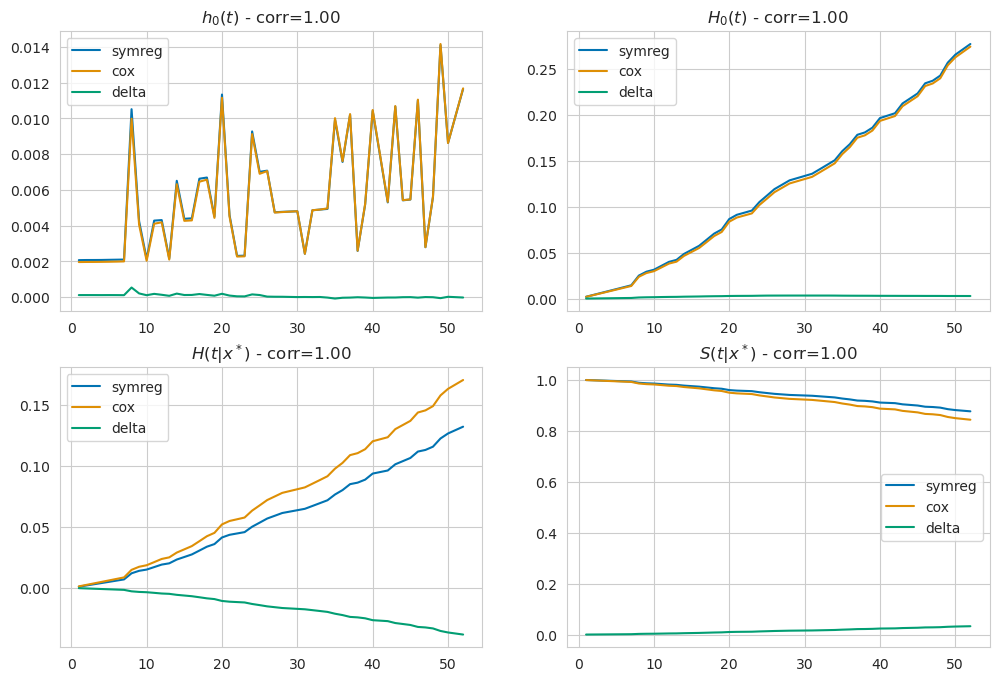

In [16]:
EvalSymRegPH(symreg_npll).score(X, T, E, sign=-1)
EvalSymRegPH(symreg_npll).plot_estimands(X, T, E)  # No scaling factor required

## 5. Non-Proportional Hazards

We switch from proportional hazards form $h(t|x) = h_0(t)\exp(g(x))$ to non-proportional hazards by allowing time to interact within $g$:

$$
h(t|x) = h_0(t)\exp(g(t|x))
$$

We retain the $h_0$ term to ensure feature-invariant components of the survival over time don't get cancelled out in the likelihood calculation.

In practice, we simply allow event time to be its own feature in the input to gplearn. This is analogous to how Cox-Time concatenates the event time to the input features.

In [ ]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox_time import CoxTime
import torchtuples as tt


class SymRegNPH(BaseEstimator, RegressorMixin, CoxTime):
    """h
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions. For non-proportional hazards.
    """

    def __init__(self, model: SymbolicRegressor, **kwargs):
        self.model = model
        self.labtrans = None

    def fit(self, X, T, E, *args, **kwargs): 
        Xt = np.hstack((X, T))
        self.model.fit(Xt, sample_weight=E)
        self.training_data = tt.tuplefy(X, (T, E))
        return self

    def predict(self, Xt_tuple, *args, **kwargs):
        X, t = Xt_tuple
        if isinstance(X, tt.TupleTree):
            X = X[0]
        Xt = np.hstack((X, t)) # Simply add the time as another column to the input just like MLPVanillaCoxTime
        return self.model.predict(Xt)

    def silent(self):
        return self.model.set_params(verbose=False)

In [ ]:
def fitness_c_shrink(y_true, y_pred, sample_weight):
    """
    Concordance index with shrink penalty for gplearn. Greater is better.
    """
    return metric_c_index(y_true, y_pred, sample_weight) - 0.05 * np.abs(y_pred).mean()


fitness_c_shrink = make_fitness(function=fitness_c_shrink, greater_is_better=True)

symreg_cs = SymRegNPH(SymbolicRegressor(
    metric=fitness_c_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.0,
    feature_names=feature_names,
    verbose=True,
)).fit(X, T, sample_weight=E)
symreg_cs.model